# Proyek Akhir : Membuat Model Sistem Rekomendasi


## Import Libraries

In [1]:
# Libraries for data manipulation and analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Libraries for splitting the data
from sklearn.model_selection import train_test_split

# Libraries for modeling
from sklearn.metrics.pairwise import linear_kernel

# Libraries for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


## Load Dataset

#### Read dataset

In [2]:
url = 'https://raw.githubusercontent.com/Ardizza/Machine-Learning-Terapan-Final-Project/main/NetflixOriginals.csv'
df = pd.read_csv(url)

## Exploratory Data Analysis (EDA)

#### 5 baris pertama dari dataset

In [3]:
print(df.head())

             Title                  Genre   Premiere  Runtime  IMDB Score  \
0  Enter the Anime            Documentary   5-Aug-19       58         2.5   
1      Dark Forces               Thriller  21-Aug-20       81         2.6   
2          The App  Science fiction/Drama  26-Dec-19       79         2.6   
3   The Open House        Horror thriller  19-Jan-18       94         3.2   
4      Kaali Khuhi                Mystery  30-Oct-20       90         3.4   

           Language  
0  English/Japanese  
1           Spanish  
2           Italian  
3           English  
4             Hindi  


#### Informasi dataset

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       584 non-null    object 
 1   Genre       584 non-null    object 
 2   Premiere    584 non-null    object 
 3   Runtime     584 non-null    int64  
 4   IMDB Score  584 non-null    float64
 5   Language    584 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 27.5+ KB
None


#### Statistik Deskriptif

#### Mengecek Jumlah Null

In [5]:
# tidak ada missing values
print(df.isnull().sum())

Title         0
Genre         0
Premiere      0
Runtime       0
IMDB Score    0
Language      0
dtype: int64


In [6]:
print(df.describe())

          Runtime  IMDB Score
count  584.000000  584.000000
mean    93.577055    6.271747
std     27.761683    0.979256
min      4.000000    2.500000
25%     86.000000    5.700000
50%     97.000000    6.350000
75%    108.000000    7.000000
max    209.000000    9.000000


### Visualisasi Data

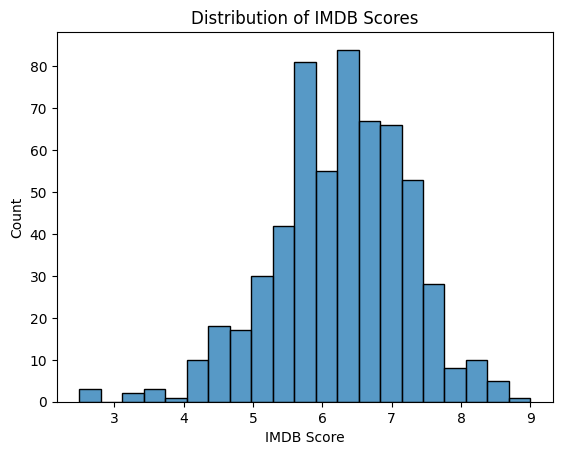

In [7]:
sns.histplot(df['IMDB Score'])
plt.title('Distribution of IMDB Scores')
plt.show()

## Data Preparation

#### Data Transformation

In [8]:
# Mengubah kolom 'Premiere' menjadi format datetime
df['Premiere'] = pd.to_datetime(df['Premiere'])

<ipython-input-8-f8f2a17b61d2>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Premiere'] = pd.to_datetime(df['Premiere'])


In [9]:
# Mengubah kolom 'Premiere' menjadi numerik (ordinal encoding)
df['Premiere'] = df['Premiere'].map(pd.Timestamp.toordinal)

In [10]:
# Encoding kolom 'Language'
le = LabelEncoder()
df['Language'] = le.fit_transform(df['Language'])

#### Normalisasi data

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['Title', 'Genre', 'IMDB Score'], axis=1))

#### TF-IDF Vectorizer

In [13]:
# Create TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english')
df['Genre'] = df['Genre'].fillna('')
tfidf_matrix = tfidf.fit_transform(df['Genre'])

#### Memisahkan fitur dan label

In [15]:
X = df_scaled
y = df['IMDB Score']

#### Split data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

### Content-Based Filtering

#### Cosine similarity matrix

In [14]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#### Get recommendations

In [15]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = df[df['Title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[movie_indices]

#### Example Recommendations

In [16]:
print("Recommendations for 'The Irishman':")
print(get_recommendations('The Irishman'))

Recommendations for 'The Irishman':
230                         Lost Girls
233                         Rogue City
287                       The Outsider
361               The Crimes That Bind
429                     The Highwaymen
461                              Ferry
491                               Soni
500    El Camino: A Breaking Bad Movie
508                         On My Skin
561                       The Irishman
Name: Title, dtype: object


### Collaborative Filtering

#### Create a pivot table

In [17]:
pivot_table = df.pivot_table(index='Title', columns='Genre', values='IMDB Score', fill_value=0)

#### Normalize ratings

In [18]:
pivot_table = pivot_table.apply(lambda x: (x - np.mean(x))/(np.max(x)-np.min(x)), axis=1)

#### Convert to matrix

In [19]:
pivot_matrix = pivot_table.to_numpy()

#### Cosine similarity

In [20]:
movie_similarity = linear_kernel(pivot_matrix, pivot_matrix)

#### Get user recommendations

In [21]:
def get_user_recommendations(title, movie_similarity=movie_similarity):
    idx = df[df['Title'] == title].index[0]
    sim_scores = list(enumerate(movie_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[movie_indices]

#### Example Recommendations

In [22]:
print("Recommendations for '13th':")
print(get_recommendations('13th'))

Recommendations for '13th':
10                  Searching for Sheela
15                        After the Raid
20     Hello Privilege. It's Me, Chelsea
30                           After Maria
36                            We Are One
80                   Strip Down, Rise Up
111                 Ghosts of Sugar Land
140                 Why Did You Kill Me?
151                             One Take
152                     Out of Many, One
Name: Title, dtype: object


## Evaluation

### Split data

In [23]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

### Create pivot tables

In [24]:
train_pivot = train_data.pivot_table(index='Title', columns='Genre', values='IMDB Score', fill_value=0)
test_pivot = test_data.pivot_table(index='Title', columns='Genre', values='IMDB Score', fill_value=0)

### Normalize ratings

In [25]:
train_pivot = train_pivot.apply(lambda x: (x - np.mean(x))/(np.max(x)-np.min(x)), axis=1)
test_pivot = test_pivot.apply(lambda x: (x - np.mean(x))/(np.max(x)-np.min(x)), axis=1)

### Convert to matrix

In [26]:
train_matrix = train_pivot.to_numpy()
test_matrix = test_pivot.to_numpy()

### Calculate similarity

In [27]:
train_similarity = linear_kernel(train_matrix, train_matrix)
test_similarity = linear_kernel(test_matrix, test_matrix)

### Mean Absolute Error (MAE)

In [28]:
def mae(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(pred, actual)

### Root Mean Squared Error (RMSE)

In [29]:
def rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

### Calculate MAE and RMSE

In [30]:
train_subset = train_matrix[:test_similarity.shape[0], :]

In [31]:
test_pred = test_similarity.dot(train_subset) / np.array([np.abs(test_similarity).sum(axis=1)]).T

print('MAE:', mae(test_pred, test_matrix[:test_similarity.shape[0], :]))
print('RMSE:', rmse(test_pred, test_matrix[:test_similarity.shape[0], :]))

MAE: 0.050730907304834115
RMSE: 0.16200401844928827
